In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
import os
import time
import seaborn as sns
from scipy.signal import periodogram
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from xgboost import XGBRegressor
import statsmodels.api as sm
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from matplotlib import gridspec
from statsmodels.graphics import tsaplots as tsa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import linregress


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ue21cs342aa2/sample_submission.csv
/kaggle/input/ue21cs342aa2/train.csv
/kaggle/input/ue21cs342aa2/test.csv


In [2]:
#test,csv path file
file_path_train = "/kaggle/input/ue21cs342aa2/train.csv"
file_path_test = "/kaggle/input/ue21cs342aa2/test.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path_train)
df_test = pd.read_csv(file_path_test)

# Display the first few rows of the DataFrame to verify the data is loaded
df.head(5)

df['Date'] = pd.to_datetime(df['Date'])

Calculating Net (Close - Open)

In [3]:
# Calculate the "Net" column
df['Net'] = df['Close'] - df['Open']


# Define the strategy for each row
df.head(100)

,id,Date,Open,Close,Volume,Strategy,Net
0,0,2015-06-01,66.208486,75.609978,298506300,Hold,9.401492
1,1,2015-06-08,64.116235,74.443331,227974800,Hold,10.327096
2,2,2015-06-15,47.701942,71.140831,250670900,Buy,23.438890
3,3,2015-06-22,54.754816,72.881344,223614300,Hold,18.126527
4,4,2015-06-29,48.031899,66.284718,406814900,Buy,18.252818
...,...,...,...,...,...,...,...
95,95,2017-03-27,80.762016,76.160757,198022000,Sell,-4.601259
96,96,2017-04-03,84.324102,77.090685,164779300,Sell,-7.233417
97,97,2017-04-10,86.318580,78.163791,190686500,Sell,-8.154788
98,98,2017-04-17,86.491174,83.218385,212678300,Sell,-3.272789


**Feature Engineering**

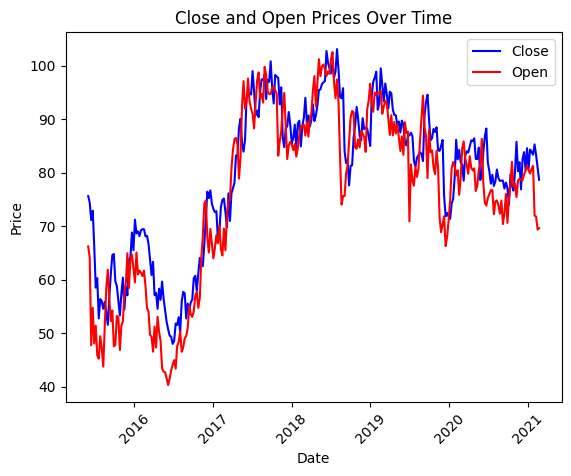

In [4]:
fig, ax = plt.subplots()
ax.plot(df['Date'], df['Close'], label='Close', color='blue')
ax.plot(df['Date'], df['Open'], label='Open', color='red')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Close and Open Prices Over Time')

# Add a legend to distinguish 'Close' and 'Open'
ax.legend()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [5]:
df['Lag_1_Open'] = df['Open'].shift(1)
df['Lag_2_Open'] = df['Open'].shift(2)
df['Lag_3_Open'] = df['Open'].shift(3)
df['Lag_4_Open'] = df['Open'].shift(4)
df['Lag_5_Open'] = df['Open'].shift(5)
df['Lag_1_Close'] = df['Close'].shift(1)
df['Lag_2_Close'] = df['Close'].shift(2)
df['Lag_3_Close'] = df['Close'].shift(3)
df['Lag_1_Volume'] = df['Volume'].shift(1)
df['Lag_2_Volume'] = df['Volume'].shift(2)
df['Lag_3_Volume'] = df['Volume'].shift(3)
df['OpenPriceDiff'] = df['Open'].diff()
df['ClosePriceDiff'] = df['Close'].diff()
df['Net_2'] = df['Net'].rolling(window = 2).mean()
df['Net_4'] = df['Net'].rolling(window = 4).mean()
df['Net%'] = ((df['Close'] - df['Open']) / df['Open']) * 100
df['OpenRoll2'] = df['Open'].rolling(window = 2).mean()
df['OpenRoll4'] = df['Open'].rolling(window = 4).mean()
df['OpenRoll8'] = df['Open'].rolling(window = 8).mean()
df['CloseRoll2'] = df['Close'].rolling(window = 2).mean()
df['CloseRoll4'] = df['Close'].rolling(window = 4).mean()
df['CloseRoll8'] = df['Close'].rolling(window = 8).mean()


df_test['Lag_1_Open'] = df_test['Open'].shift(1)
df_test['Lag_2_Open'] = df_test['Open'].shift(2)
df_test['Lag_3_Open'] = df_test['Open'].shift(3)
df_test['Lag_4_Open'] = df_test['Open'].shift(4)
df_test['Lag_5_Open'] = df_test['Open'].shift(5)

df_test['Lag_1_Volume'] = df_test['Volume'].shift(1)
df_test['Lag_2_Volume'] = df_test['Volume'].shift(2)
df_test['Lag_3_Volume'] = df_test['Volume'].shift(3)
df_test['OpenPriceDiff'] = df_test['Open'].diff()
df_test['OpenRoll2'] = df_test['Open'].rolling(window = 2).mean()
df_test['OpenRoll4'] = df_test['Open'].rolling(window = 4).mean()
df_test['OpenRoll8'] = df_test['Open'].rolling(window = 8).mean()

'''
df_test['ClosePriceDiff'] = df_test['Close'].diff()
df_test['Net_2'] = df_test['Net'].rolling(window = 2).mean()
df_test['Net_3'] = df_test['Net'].rolling(window = 2).mean()
df_test['Net%'] = ((df_test['Close'] - df_test['Open']) / df['Open']) * 100
df_test['Lag_1_Close'] = df_test['Close'].shift(1)

'''

df.head(100)

,id,Date,Open,Close,Volume,Strategy,Net,Lag_1_Open,Lag_2_Open,Lag_3_Open,...,ClosePriceDiff,Net_2,Net_4,Net%,OpenRoll2,OpenRoll4,OpenRoll8,CloseRoll2,CloseRoll4,CloseRoll8
0,0,2015-06-01,66.208486,75.609978,298506300,Hold,9.401492,NaN,NaN,NaN,...,NaN,NaN,NaN,14.199830,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2015-06-08,64.116235,74.443331,227974800,Hold,10.327096,66.208486,NaN,NaN,...,-1.166647,9.864294,NaN,16.106834,65.162361,NaN,NaN,75.026655,NaN,NaN
2,2,2015-06-15,47.701942,71.140831,250670900,Buy,23.438890,64.116235,66.208486,NaN,...,-3.302500,16.882993,NaN,49.136133,55.909088,NaN,NaN,72.792081,NaN,NaN
3,3,2015-06-22,54.754816,72.881344,223614300,Hold,18.126527,47.701942,64.116235,66.208486,...,1.740512,20.782709,15.323501,33.104900,51.228379,58.195370,NaN,72.011087,73.518871,NaN
4,4,2015-06-29,48.031899,66.284718,406814900,Buy,18.252818,54.754816,47.701942,64.116235,...,-6.596626,18.189673,17.536333,38.001450,51.393358,53.651223,NaN,69.583031,71.187556,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,2017-03-27,80.762016,76.160757,198022000,Sell,-4.601259,75.004757,74.684910,71.813121,...,5.181718,-4.313488,-2.307367,-5.697305,77.883386,75.566201,70.939235,73.569898,73.258833,73.670536
96,96,2017-04-03,84.324102,77.090685,164779300,Sell,-7.233417,80.762016,75.004757,74.684910,...,0.929928,-5.917338,-3.604337,-8.578113,82.543059,78.693946,73.266144,76.625721,75.089609,74.105660
97,97,2017-04-10,86.318580,78.163791,190686500,Sell,-8.154788,84.324102,80.762016,75.004757,...,1.073106,-7.694103,-6.003795,-9.447315,85.321341,81.602364,75.990681,77.627238,75.598568,74.512680
98,98,2017-04-17,86.491174,83.218385,212678300,Sell,-3.272789,86.318580,84.324102,80.762016,...,5.054594,-5.713789,-5.815563,-3.783957,86.404877,84.473968,78.108941,80.691088,78.658405,75.519510


In [6]:
df['OpenPriceDiffRoll2'] = df['OpenPriceDiff'].rolling(window = 2).mean()
df['OpenPriceDiffRoll4'] = df['OpenPriceDiff'].rolling(window = 4).mean()
df['ClosePriceDiffRoll2'] = df['ClosePriceDiff'].rolling(window = 2).mean()
df['ClosePriceDiffRoll4'] = df['ClosePriceDiff'].rolling(window = 4).mean()
df['OpenPriceDiffRoll3'] = df['OpenPriceDiff'].rolling(window=3).mean()
df['OpenPriceDiffRoll5'] = df['OpenPriceDiff'].rolling(window=5).mean()
df['Net%Roll2'] = df['Net%'].rolling(window=2).mean()
df['Net%Roll4'] = df['Net%'].rolling(window=4).mean()
df['Net%Roll3'] = df['Net%'].rolling(window=3).mean()
df['Net%Roll5'] = df['Net%'].rolling(window=5).mean()

# Assuming you have the same columns in df_test

df_test['OpenPriceDiffRoll2'] = df_test['OpenPriceDiff'].rolling(window=2).mean()
df_test['OpenPriceDiffRoll4'] = df_test['OpenPriceDiff'].rolling(window=4).mean()
'''
df_test['ClosePriceDiffRoll2'] = df_test['ClosePriceDiff'].rolling(window=2).mean()
df_test['ClosePriceDiffRoll4'] = df_test['ClosePriceDiff'].rolling(window=4).mean()
'''
df_test['OpenPriceDiffRoll3'] = df_test['OpenPriceDiff'].rolling(window=3).mean()
df_test['OpenPriceDiffRoll5'] = df_test['OpenPriceDiff'].rolling(window=5).mean()
'''
df_test['Net%Roll2'] = df_test['Net%'].rolling(window=2).mean()
df_test['Net%Roll4'] = df_test['Net%'].rolling(window=4).mean()
df_test['Net%Roll3'] = df_test['Net%'].rolling(window=3).mean()
df_test['Net%Roll5'] = df_test['Net%'].rolling(window=5).mean()
df_test['ClosePriceDiffRoll2'] = df_test['ClosePriceDiff'].rolling(window=2).mean()
df_test['ClosePriceDiffRoll4'] = df_test['ClosePriceDiff'].rolling(window=4).mean()
'''



"\ndf_test['Net%Roll2'] = df_test['Net%'].rolling(window=2).mean()\ndf_test['Net%Roll4'] = df_test['Net%'].rolling(window=4).mean()\ndf_test['Net%Roll3'] = df_test['Net%'].rolling(window=3).mean()\ndf_test['Net%Roll5'] = df_test['Net%'].rolling(window=5).mean()\ndf_test['ClosePriceDiffRoll2'] = df_test['ClosePriceDiff'].rolling(window=2).mean()\ndf_test['ClosePriceDiffRoll4'] = df_test['ClosePriceDiff'].rolling(window=4).mean()\n"

In [7]:

lag_features = ['Lag_1_Open', 'Lag_2_Open', 'Lag_3_Open',
                'Lag_4_Open', 'Lag_5_Open', 'Lag_1_Close',
                'Lag_1_Volume',
                'Lag_2_Volume', 'Lag_3_Volume','OpenPriceDiff',
                'Net_2','Net_4','ClosePriceDiff','OpenPriceDiffRoll2',
                'OpenPriceDiffRoll4','ClosePriceDiffRoll2',
                'ClosePriceDiffRoll4','OpenPriceDiffRoll3',
                'OpenPriceDiffRoll5','Net%Roll2','Net%Roll3','Net%Roll4','Net%Roll5','OpenRoll2',
                'OpenRoll4','OpenRoll8',
                'Lag_1_Close','Lag_2_Close','Lag_3_Close',
                'CloseRoll2','CloseRoll4','CloseRoll8'
                
               ]

for feature in lag_features:
    df[feature].fillna(df[feature].mean(), inplace=True)

In [8]:

lag_features = ['Lag_1_Open', 'Lag_2_Open', 'Lag_3_Open',
                'Lag_4_Open', 'Lag_5_Open', 
                'Lag_1_Volume',
                'Lag_2_Volume', 'Lag_3_Volume','OpenPriceDiff',
                'OpenPriceDiffRoll2',
                'OpenPriceDiffRoll4',
                'OpenPriceDiffRoll3',
                'OpenPriceDiffRoll5',
                'OpenRoll2','OpenRoll4','OpenRoll8'
               ]

for feature in lag_features:
    df_test[feature].fillna(df_test[feature].mean(), inplace=True)

In [9]:
df_test['Open_MA_Lag2_4'] = df_test['Lag_2_Open'].rolling(window=4).mean()
df_test['Open_MA_Lag2_2'] = df_test['Lag_2_Open'].rolling(window=2).mean()
df['Open_MA_Lag2_4'] = df['Lag_2_Open'].rolling(window=4).mean()
df['Open_MA_Lag2_2'] = df['Lag_2_Open'].rolling(window=2).mean()

In [10]:
decomposition = sm.tsa.seasonal_decompose(df_test['Open'], model='additive', period=26) 

In [11]:
df['Open_Seasonal'] = decomposition.seasonal
df['Open_Trend'] = decomposition.trend
df['Open_Residual'] = decomposition.resid

In [12]:
decomposition1 = sm.tsa.seasonal_decompose(df_test['Open'], model='additive', period=26) 

In [13]:
df_test['Open_Seasonal'] = decomposition1.seasonal
df_test['Open_Trend'] = decomposition1.trend
df_test['Open_Residual'] = decomposition1.resid

In [14]:
lag_features = ['Open_Seasonal',
                'Open_Trend',
                'Open_Residual'
               ]

for feature in lag_features:
    df[feature].fillna(df[feature].mean(), inplace=True)

In [15]:
lag_features = ['Open_Seasonal',
                'Open_Trend',
                'Open_Residual'
               ]

for feature in lag_features:
    df_test[feature].fillna(df_test[feature].mean(), inplace=True)

In [16]:
lag_features = ['Open_MA_Lag2_4', 'Open_MA_Lag2_2']
for feature in lag_features:
    df[feature].fillna(df[feature].mean(), inplace=True)

In [17]:
lag_features = ['Open_MA_Lag2_4', 'Open_MA_Lag2_2']
for feature in lag_features:
    df_test[feature].fillna(df_test[feature].mean(), inplace=True)

In [18]:

df_test.head(10)

,id,Date,Open,Volume,Lag_1_Open,Lag_2_Open,Lag_3_Open,Lag_4_Open,Lag_5_Open,Lag_1_Volume,...,OpenRoll8,OpenPriceDiffRoll2,OpenPriceDiffRoll4,OpenPriceDiffRoll3,OpenPriceDiffRoll5,Open_MA_Lag2_4,Open_MA_Lag2_2,Open_Seasonal,Open_Trend,Open_Residual
0,0,2021-03-01,72.708331,205897600,70.398916,70.551479,70.645342,70.750297,70.894525,1.977245e+08,...,70.687969,-0.171238,-0.136490,-0.146824,-0.133941,70.702571,70.597462,-3.434480,72.280007,0.503704
1,1,2021-03-08,73.310886,214095600,72.708331,70.551479,70.645342,70.750297,70.894525,2.058976e+08,...,70.687969,-0.171238,-0.136490,-0.146824,-0.133941,70.702571,70.551479,1.973019,72.280007,0.503704
2,2,2021-03-15,70.610119,151601700,73.310886,72.708331,70.645342,70.750297,70.894525,2.140956e+08,...,70.687969,-1.049106,-0.136490,-0.146824,-0.133941,70.702571,71.629905,3.092108,72.280007,0.503704
3,3,2021-03-22,70.256017,193982500,70.610119,73.310886,72.708331,70.750297,70.894525,1.516017e+08,...,70.687969,-1.527435,-0.136490,-0.817438,-0.133941,71.780544,73.009609,1.188503,72.280007,0.503704
4,4,2021-03-29,68.258324,220238400,70.256017,70.610119,73.310886,72.708331,70.894525,1.939825e+08,...,70.687969,-1.175897,-1.112502,-1.684187,-0.133941,71.795204,71.960503,0.770086,72.280007,0.503704
5,5,2021-04-05,69.625390,252489500,68.258324,70.256017,70.610119,73.310886,72.708331,2.202384e+08,...,70.687969,-0.315313,-0.921374,-0.328243,-0.616588,71.721338,70.433068,2.205276,72.280007,0.503704
6,6,2021-04-12,72.046746,178234600,69.625390,68.258324,70.256017,70.610119,73.310886,2.524895e+08,...,70.687969,1.894211,0.359157,0.596910,-0.252828,70.608836,69.257170,5.826092,72.280007,0.503704
7,7,2021-04-19,71.426418,194482300,72.046746,69.625390,68.258324,70.256017,70.610119,1.782346e+08,...,71.030279,0.900514,0.292600,1.056031,0.163260,69.687463,68.941857,3.877394,72.280007,0.503704
8,8,2021-04-26,70.060497,235236100,71.426418,72.046746,69.625390,68.258324,70.256017,1.944823e+08,...,70.699300,-0.993124,0.450543,0.145036,-0.039104,70.046619,70.836068,3.057576,72.280007,0.503704
9,9,2021-05-03,68.483296,195113500,70.060497,71.426418,72.046746,69.625390,68.258324,2.352361e+08,...,70.095851,-1.471561,-0.285524,-1.187817,0.044994,70.339220,71.736582,6.808804,72.280007,0.503704


In [19]:
df.head(10)

,id,Date,Open,Close,Volume,Strategy,Net,Lag_1_Open,Lag_2_Open,Lag_3_Open,...,OpenPriceDiffRoll5,Net%Roll2,Net%Roll4,Net%Roll3,Net%Roll5,Open_MA_Lag2_4,Open_MA_Lag2_2,Open_Seasonal,Open_Trend,Open_Residual
0,0,2015-06-01,66.208486,75.609978,298506300,Hold,9.401492,75.999081,76.021319,76.035584,...,0.056418,5.892336,5.798893,5.860085,5.734888,76.042667,76.028403,-3.434480,72.280007,0.503704
1,1,2015-06-08,64.116235,74.443331,227974800,Hold,10.327096,66.208486,76.021319,76.035584,...,0.056418,15.153332,5.798893,5.860085,5.734888,76.042667,76.021319,1.973019,72.280007,0.503704
2,2,2015-06-15,47.701942,71.140831,250670900,Buy,23.438890,64.116235,66.208486,76.035584,...,0.056418,32.621484,5.798893,26.480932,5.734888,76.042667,71.114902,3.092108,72.280007,0.503704
3,3,2015-06-22,54.754816,72.881344,223614300,Hold,18.126527,47.701942,64.116235,66.208486,...,0.056418,41.120517,28.136924,32.782623,5.734888,70.591840,65.162361,1.188503,72.280007,0.503704
4,4,2015-06-29,48.031899,66.284718,406814900,Buy,18.252818,54.754816,47.701942,64.116235,...,0.056418,35.553175,34.087330,40.080828,30.109830,63.511995,55.909088,0.770086,72.280007,0.503704
5,5,2015-07-06,51.374399,58.494017,590857400,Buy,7.119618,48.031899,54.754816,47.701942,...,-2.966817,25.929875,33.525196,28.321550,30.041523,58.195370,51.228379,2.205276,72.280007,0.503704
6,6,2015-07-13,45.851376,60.269347,693570200,Buy,14.417971,51.374399,48.031899,54.754816,...,-3.652972,22.651656,29.102416,27.768254,33.109159,53.651223,51.393358,5.826092,72.280007,0.503704
7,7,2015-07-20,45.200332,52.738477,326224700,Buy,7.538146,45.851376,51.374399,48.031899,...,-0.500322,24.061102,24.995488,20.660168,26.617371,50.465764,49.703149,3.877394,72.280007,0.503704
8,8,2015-07-27,49.402806,56.363684,288132300,Buy,6.960878,45.200332,45.851376,51.374399,...,-1.070402,15.383618,19.017637,20.737417,22.814400,50.003123,48.612887,3.057576,72.280007,0.503704
9,9,2015-08-03,47.101190,55.975242,294538600,Buy,8.874052,49.402806,45.200332,45.851376,...,-0.186142,16.465223,20.263163,16.535879,18.982190,47.614501,45.525854,6.808804,72.280007,0.503704


In [20]:

df['Spread_Percentage'] = (df['Close'] - df['Open']) / df['Close']
df['Volume_Price_Impact'] = df['Volume'] * (df['Close'] - df['Open'])
df['Volume_Percentage_of_Prev'] = (df['Volume'] / df['Lag_1_Volume'])

'''

df_test['Spread_Percentage'] = (df_test['Close'] - df_test['Open']) / df_test['Close']
df_test['Volume_Price_Impact'] = df_test['Volume'] * (df_test['Close'] - df_test['Open'])
df_test['Volume_Percentage_of_Prev'] = (df_test['Volume'] / df_test['Lag_1_Volume'])
'''

"\n\ndf_test['Spread_Percentage'] = (df_test['Close'] - df_test['Open']) / df_test['Close']\ndf_test['Volume_Price_Impact'] = df_test['Volume'] * (df_test['Close'] - df_test['Open'])\ndf_test['Volume_Percentage_of_Prev'] = (df_test['Volume'] / df_test['Lag_1_Volume'])\n"

In [21]:
lag_features = ['Spread_Percentage', 'Volume_Price_Impact','Volume_Percentage_of_Prev']
for feature in lag_features:
    df[feature].fillna(df[feature].mean(), inplace=True)

In [22]:
"""
lag_features = ['Spread_Percentage', 'Volume_Price_Impact','Volume_Percentage_of_Prev']
for feature in lag_features:
    df_test[feature].fillna(df[feature].mean(), inplace=True)
"""

"\nlag_features = ['Spread_Percentage', 'Volume_Price_Impact','Volume_Percentage_of_Prev']\nfor feature in lag_features:\n    df_test[feature].fillna(df[feature].mean(), inplace=True)\n"

In [23]:
from scipy.stats import linregress
column_pairs = [
    ('Lag_1_Open', 'Lag_1_Close'),
    ('Lag_1_Open', 'Spread_Percentage'),
    ('ClosePriceDiff', 'Volume_Price_Impact'),
    ('OpenPriceDiff','Net'),
    ('ClosePriceDiff','Net'),
    ('Spread_Percentage','Net'),
    ('Volume_Price_Impact','Net'),
    ('Volume_Percentage_of_Prev','Net'),
    ('Spread_Percentage','Lag_1_Open'),
    ('Volume_Price_Impact','Lag_1_Open'),
    ('Volume_Percentage_of_Prev','Lag_1_Open'),
    
    # Add more column pairs as needed
]

# Calculate R^2 for each column pair
for col1, col2 in column_pairs:
    result = linregress(df[col1], df[col2])
    r_squared = result.rvalue ** 2
    print(f"R^2 value between {col1} and {col2}: {r_squared}")


R^2 value between Lag_1_Open and Lag_1_Close: 0.8611263659391029
R^2 value between Lag_1_Open and Spread_Percentage: 0.2676395143479678
R^2 value between ClosePriceDiff and Volume_Price_Impact: 0.0006748859523806931
R^2 value between OpenPriceDiff and Net: 0.2747230664813747
R^2 value between ClosePriceDiff and Net: 0.006961153313562618
R^2 value between Spread_Percentage and Net: 0.9522811329125591
R^2 value between Volume_Price_Impact and Net: 0.7579122987647497
R^2 value between Volume_Percentage_of_Prev and Net: 0.0008209969964995446
R^2 value between Spread_Percentage and Lag_1_Open: 0.2676395143479678
R^2 value between Volume_Price_Impact and Lag_1_Open: 0.21218600705683963
R^2 value between Volume_Percentage_of_Prev and Lag_1_Open: 9.52616304777252e-05


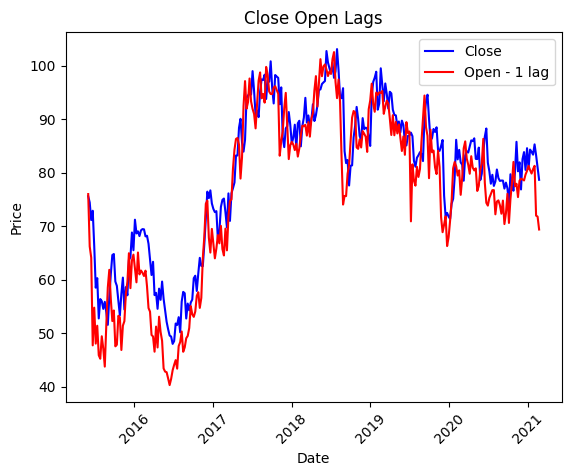

In [24]:
fig, ax = plt.subplots()
ax.plot(df['Date'], df['Close'], label='Close', color='blue')
ax.plot(df['Date'], df['Lag_1_Open'], label='Open - 1 lag', color='red')


# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Close Open Lags')

# Add a legend to distinguish 'Close' and 'Open'
ax.legend()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [25]:
df.head()

,id,Date,Open,Close,Volume,Strategy,Net,Lag_1_Open,Lag_2_Open,Lag_3_Open,...,Net%Roll3,Net%Roll5,Open_MA_Lag2_4,Open_MA_Lag2_2,Open_Seasonal,Open_Trend,Open_Residual,Spread_Percentage,Volume_Price_Impact,Volume_Percentage_of_Prev
0,0,2015-06-01,66.208486,75.609978,298506300,Hold,9.401492,75.999081,76.021319,76.035584,...,5.860085,5.734888,76.042667,76.028403,-3.434480,72.280007,0.503704,0.124342,2.806405e+09,1.603661
1,1,2015-06-08,64.116235,74.443331,227974800,Hold,10.327096,66.208486,76.021319,76.035584,...,5.860085,5.734888,76.042667,76.021319,1.973019,72.280007,0.503704,0.138724,2.354318e+09,0.763719
2,2,2015-06-15,47.701942,71.140831,250670900,Buy,23.438890,64.116235,66.208486,76.035584,...,26.480932,5.734888,76.042667,71.114902,3.092108,72.280007,0.503704,0.329472,5.875448e+09,1.099555
3,3,2015-06-22,54.754816,72.881344,223614300,Hold,18.126527,47.701942,64.116235,66.208486,...,32.782623,5.734888,70.591840,65.162361,1.188503,72.280007,0.503704,0.248713,4.053351e+09,0.892063
4,4,2015-06-29,48.031899,66.284718,406814900,Buy,18.252818,54.754816,47.701942,64.116235,...,40.080828,30.109830,63.511995,55.909088,0.770086,72.280007,0.503704,0.275370,7.425518e+09,1.819271


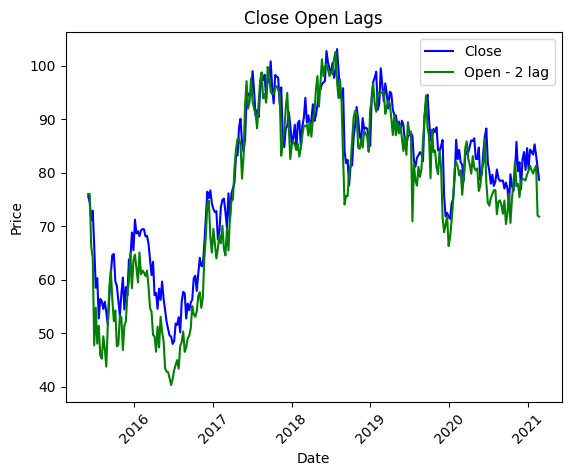

In [26]:
fig, ax = plt.subplots()
ax.plot(df['Date'], df['Close'], label='Close', color='blue')
ax.plot(df['Date'], df['Lag_2_Open'], label='Open - 2 lag', color='Green')


# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Close Open Lags')

# Add a legend to distinguish 'Close' and 'Open'
ax.legend()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.show()

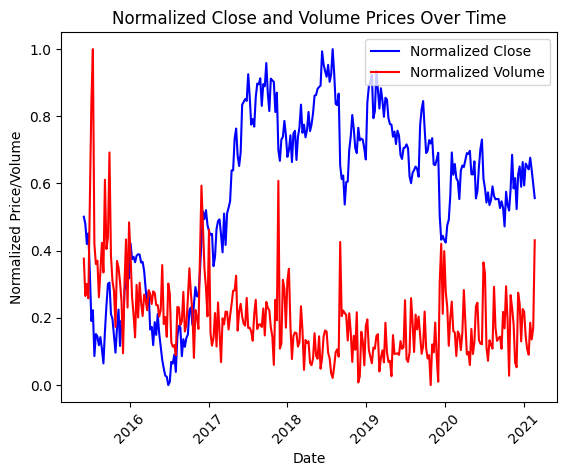

In [27]:
scaler = MinMaxScaler()

# Normalize the 'Close' and 'Volume' columns
df['Close_normalized'] = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
df['Volume_normalized'] = scaler.fit_transform(df['Volume'].values.reshape(-1, 1))
df['Open_normalized'] = scaler.fit_transform(df['Open'].values.reshape(-1, 1))



fig, ax = plt.subplots()
ax.plot(df['Date'], df['Close_normalized'], label='Normalized Close', color='blue')
ax.plot(df['Date'], df['Volume_normalized'], label='Normalized Volume', color='red')

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Price/Volume')
ax.set_title('Normalized Close and Volume Prices Over Time')

# Add a legend to distinguish 'Normalized Close' and 'Normalized Volume'
ax.legend()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [28]:

df['Daily_Return'] = (df['Close'] - df['Lag_1_Close']) 
'''
df_test['Daily_Return'] = (df_test['Close'] - df_test['Lag_1_Close'])
'''



"\ndf_test['Daily_Return'] = (df_test['Close'] - df_test['Lag_1_Close'])\n"

In [29]:
lag_features = ['Daily_Return']

for feature in lag_features:
    df[feature].fillna(df[feature].mean(), inplace=True)

In [30]:
"""
lag_features = ['Daily_Return']

for feature in lag_features:
    df_test[feature].fillna(df_test[feature].mean(), inplace=True)

"""

"\nlag_features = ['Daily_Return']\n\nfor feature in lag_features:\n    df_test[feature].fillna(df_test[feature].mean(), inplace=True)\n\n"

In [31]:
df['DPR'] = df['Daily_Return']/df['Lag_1_Close']

In [32]:
"""
df_test['DPR'] = df_test['Daily_Return']/df_test['Lag_1_Close']
"""

"\ndf_test['DPR'] = df_test['Daily_Return']/df_test['Lag_1_Close']\n"

In [33]:

df['Close-PrevClose'] = np.abs(df['Close'] - df['Open'].shift(1))
df['Open-PrevClose'] = np.abs(df['Open'] - df['Close'].shift(1))
df['TR'] = df[['Net', 'Close-PrevClose', 'Open-PrevClose']].max(axis=1)



In [34]:
'''

df_test['Close-PrevClose'] = np.abs(df_test['Close'] - df_test['Open'].shift(1))
df_test['Open-PrevClose'] = np.abs(df_test['Open'] - df_test['Close'].shift(1))
df_test['TR'] = df_test[['Net', 'Close-PrevClose', 'Open-PrevClose']].max(axis=1)
'''

"\n\ndf_test['Close-PrevClose'] = np.abs(df_test['Close'] - df_test['Open'].shift(1))\ndf_test['Open-PrevClose'] = np.abs(df_test['Open'] - df_test['Close'].shift(1))\ndf_test['TR'] = df_test[['Net', 'Close-PrevClose', 'Open-PrevClose']].max(axis=1)\n"

In [35]:
df['ATR'] = df['TR'].rolling(window=4).mean()

In [36]:
"""
df_test['ATR'] = df_test['TR'].rolling(window=4).mean()
"""

"\ndf_test['ATR'] = df_test['TR'].rolling(window=4).mean()\n"

In [37]:
lag_features = ['Daily_Return','TR','ATR','DPR'
               ]

for feature in lag_features:
    df[feature].fillna(df[feature].mean(), inplace=True)

In [38]:
"""
lag_features = ['Daily_Return','TR','ATR','DPR'
               ]
​
for feature in lag_features:
    df_test[feature].fillna(df_test[feature].mean(), inplace=True)
"""

"\nlag_features = ['Daily_Return','TR','ATR','DPR'\n               ]\n\u200b\nfor feature in lag_features:\n    df_test[feature].fillna(df_test[feature].mean(), inplace=True)\n"

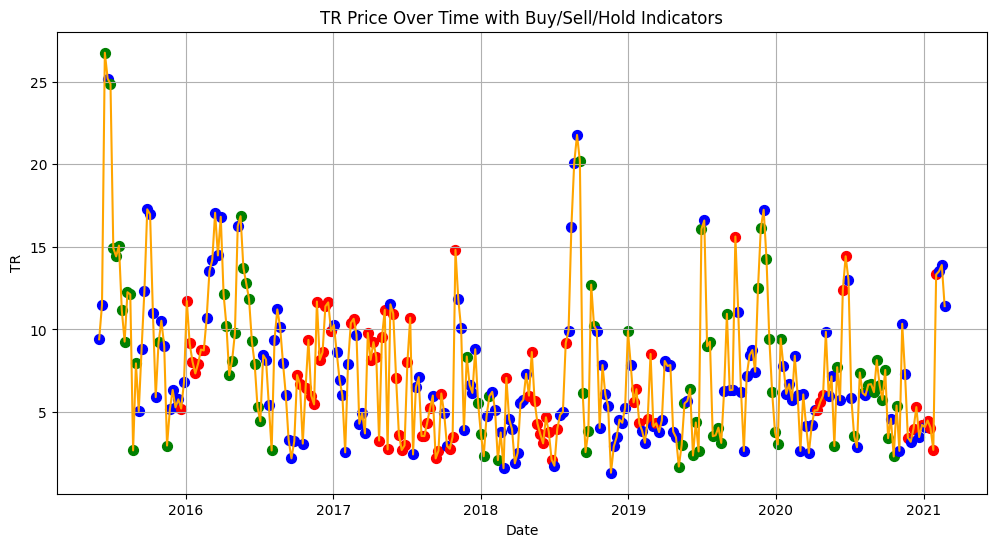

In [39]:
colors = {'Buy': 'green', 'Sell': 'red', 'Hold': 'blue'}

# Plot Open
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['TR'], label='TR', color='orange')

# Add dots to indicate Buy, Sell, and Hold
for index, row in df.iterrows():
    plt.scatter(row['Date'], row['TR'], c=colors[row['Strategy']], label=row['Strategy'], s=50)

plt.title('TR Price Over Time with Buy/Sell/Hold Indicators')
plt.xlabel('Date')
plt.ylabel('TR')
plt.grid(True)

plt.show()

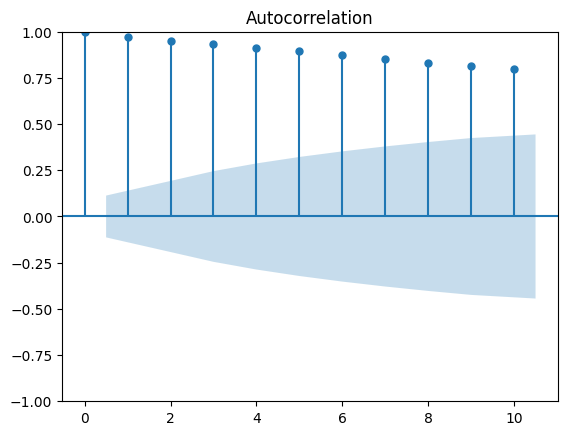

In [40]:
plot_acf(df['Close'],lags=10)
plt.show()

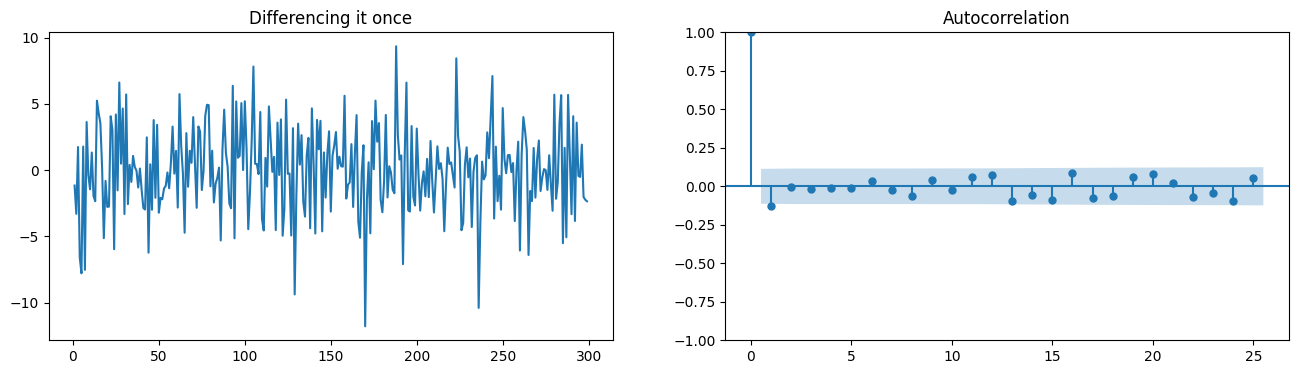

In [41]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,4))

ax1.plot(diff)
ax1.set_title("Differencing it once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax = ax2);

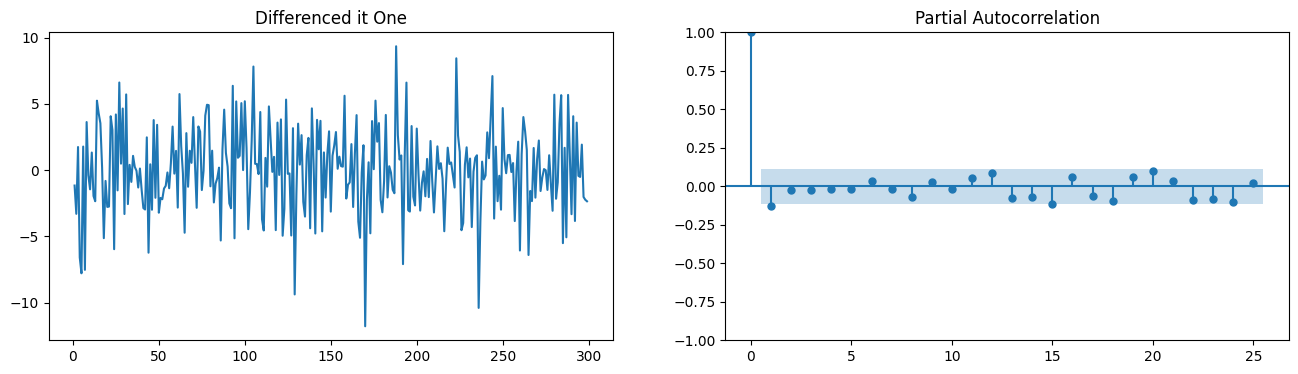

In [42]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16,4))

ax1.plot(diff)
ax1.set_title("Differenced it One")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax = ax2);

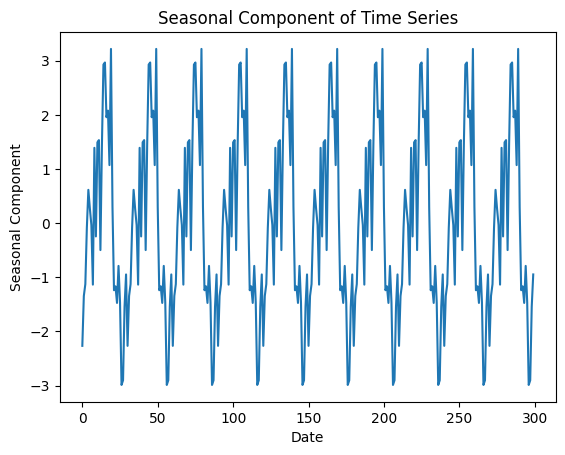

In [43]:
# Decompose the time series using an additive model with daily frequency
decomposition_additive = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=30)

# Extract the seasonal component
seasonal_component = decomposition_additive.seasonal
plt.plot(seasonal_component)
plt.xlabel('Date')
plt.ylabel('Seasonal Component')
plt.title('Seasonal Component of Time Series')
plt.show()

In [44]:
df.head()

,id,Date,Open,Close,Volume,Strategy,Net,Lag_1_Open,Lag_2_Open,Lag_3_Open,...,Volume_Percentage_of_Prev,Close_normalized,Volume_normalized,Open_normalized,Daily_Return,DPR,Close-PrevClose,Open-PrevClose,TR,ATR
0,0,2015-06-01,66.208486,75.609978,298506300,Hold,9.401492,75.999081,76.021319,76.035584,...,1.603661,0.501099,0.376533,0.416431,-3.823048,-0.048129,NaN,NaN,9.401492,7.414227
1,1,2015-06-08,64.116235,74.443331,227974800,Hold,10.327096,66.208486,76.021319,76.035584,...,0.763719,0.479941,0.265225,0.382842,-1.166647,-0.015430,8.234845,11.493743,11.493743,7.414227
2,2,2015-06-15,47.701942,71.140831,250670900,Buy,23.438890,64.116235,66.208486,76.035584,...,1.099555,0.420048,0.301042,0.119323,-3.302500,-0.044363,7.024596,26.741389,26.741389,7.414227
3,3,2015-06-22,54.754816,72.881344,223614300,Hold,18.126527,47.701942,64.116235,66.208486,...,0.892063,0.451614,0.258343,0.232552,1.740512,0.024466,25.179402,16.386015,25.179402,18.204007
4,4,2015-06-29,48.031899,66.284718,406814900,Buy,18.252818,54.754816,47.701942,64.116235,...,1.819271,0.331980,0.547460,0.124620,-6.596626,-0.090512,11.529902,24.849444,24.849444,22.065995


In [45]:
# Define the period for RSI (e.g., 14 days)
rsi_period = 4

# Calculate price changes
delta = df['ClosePriceDiff']

# Calculate average gain and average loss
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=rsi_period).mean()
avg_loss = loss.rolling(window=rsi_period).mean()

# Calculate the relative strength (RS) and RSI
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

# Add RSI to the DataFrame if desired
df['RSI'] = rsi



In [46]:
# Define the short-term and long-term periods
short_term_period = 12
long_term_period = 26

# Calculate the short-term exponential moving average (EMA)
short_term_ema = df['Close'].ewm(span=short_term_period, adjust=False).mean()

# Calculate the long-term exponential moving average (EMA)
long_term_ema = df['Close'].ewm(span=long_term_period, adjust=False).mean()

# Calculate the MACD line
macd_line = short_term_ema - long_term_ema

# Calculate the signal line
signal_period = 9
signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()


In [47]:
# Define the period and number of standard deviations
bb_period = 5
num_std = 2

# Calculate the SMA (Simple Moving Average)
sma = df['Close'].rolling(window=bb_period).mean()

# Calculate the standard deviation
std = df['Close'].rolling(window=bb_period).std()

# Calculate the upper and lower Bollinger Bands
upper_bb = sma + (num_std * std)
lower_bb = sma - (num_std * std)



In [48]:
# Calculate OBV based on 'Volume'
df['OBV'] = df['Volume'] * (2 * (df['Close'] > df['Close'].shift()) - 1)
df['OBV'] = df['OBV'].cumsum()


In [49]:
df['RSI'] = rsi
df['MACD'] = macd_line
df['Signal Line'] = signal_line
df['Upper Band'] = upper_bb
df['Lower Band'] = lower_bb

In [50]:
df.head(10)

,id,Date,Open,Close,Volume,Strategy,Net,Lag_1_Open,Lag_2_Open,Lag_3_Open,...,Close-PrevClose,Open-PrevClose,TR,ATR,RSI,OBV,MACD,Signal Line,Upper Band,Lower Band
0,0,2015-06-01,66.208486,75.609978,298506300,Hold,9.401492,75.999081,76.021319,76.035584,...,NaN,NaN,9.401492,7.414227,NaN,-298506300,0.000000,0.000000,NaN,NaN
1,1,2015-06-08,64.116235,74.443331,227974800,Hold,10.327096,66.208486,76.021319,76.035584,...,8.234845,11.493743,11.493743,7.414227,NaN,-526481100,-0.093066,-0.018613,NaN,NaN
2,2,2015-06-15,47.701942,71.140831,250670900,Buy,23.438890,64.116235,66.208486,76.035584,...,7.024596,26.741389,26.741389,7.414227,NaN,-777152000,-0.428367,-0.100564,NaN,NaN
3,3,2015-06-22,54.754816,72.881344,223614300,Hold,18.126527,47.701942,64.116235,66.208486,...,25.179402,16.386015,25.179402,18.204007,28.147608,-553537700,-0.547342,-0.189920,NaN,NaN
4,4,2015-06-29,48.031899,66.284718,406814900,Buy,18.252818,54.754816,47.701942,64.116235,...,11.529902,24.849444,24.849444,22.065995,13.591078,-960352600,-1.160545,-0.384045,79.362805,64.781276
5,5,2015-07-06,51.374399,58.494017,590857400,Buy,7.119618,48.031899,54.754816,47.701942,...,10.462117,14.910319,14.910319,22.920139,8.957703,-1551210000,-2.249229,-0.757082,81.548838,55.748858
6,6,2015-07-13,45.851376,60.269347,693570200,Buy,14.417971,51.374399,48.031899,54.754816,...,8.894948,12.642641,14.417971,19.839284,19.638101,-857639800,-2.934933,-1.192652,78.576080,53.052022
7,7,2015-07-20,45.200332,52.738477,326224700,Buy,7.538146,45.851376,51.374399,48.031899,...,6.887102,15.069015,15.069015,17.311687,7.492892,-1183864500,-4.039472,-1.762016,77.552274,46.714887
8,8,2015-07-27,49.402806,56.363684,288132300,Buy,6.960878,45.200332,45.851376,51.374399,...,11.163353,3.335671,11.163353,13.890165,26.061718,-895732200,-4.569627,-2.323538,68.877276,48.782821
9,9,2015-08-03,47.101190,55.975242,294538600,Buy,8.874052,49.402806,45.200332,45.851376,...,6.572436,9.262495,9.262495,12.478208,40.545034,-1190270800,-4.963903,-2.851611,62.448607,51.087700


In [51]:
lag_features = ['RSI','MACD','Signal Line','Upper Band','Lower Band','OBV'
               ]
for feature in lag_features:
    df[feature].fillna(df[feature].mean(), inplace=True)

Splitting Train and Test

In [52]:
train = df.iloc[0:(len(df)-7)]
test = df.iloc[len(train):(len(df)-1)]

In [53]:
train.head()

,id,Date,Open,Close,Volume,Strategy,Net,Lag_1_Open,Lag_2_Open,Lag_3_Open,...,Close-PrevClose,Open-PrevClose,TR,ATR,RSI,OBV,MACD,Signal Line,Upper Band,Lower Band
0,0,2015-06-01,66.208486,75.609978,298506300,Hold,9.401492,75.999081,76.021319,76.035584,...,NaN,NaN,9.401492,7.414227,50.163177,-298506300,0.000000,0.000000,84.896492,74.015947
1,1,2015-06-08,64.116235,74.443331,227974800,Hold,10.327096,66.208486,76.021319,76.035584,...,8.234845,11.493743,11.493743,7.414227,50.163177,-526481100,-0.093066,-0.018613,84.896492,74.015947
2,2,2015-06-15,47.701942,71.140831,250670900,Buy,23.438890,64.116235,66.208486,76.035584,...,7.024596,26.741389,26.741389,7.414227,50.163177,-777152000,-0.428367,-0.100564,84.896492,74.015947
3,3,2015-06-22,54.754816,72.881344,223614300,Hold,18.126527,47.701942,64.116235,66.208486,...,25.179402,16.386015,25.179402,18.204007,28.147608,-553537700,-0.547342,-0.189920,84.896492,74.015947
4,4,2015-06-29,48.031899,66.284718,406814900,Buy,18.252818,54.754816,47.701942,64.116235,...,11.529902,24.849444,24.849444,22.065995,13.591078,-960352600,-1.160545,-0.384045,79.362805,64.781276


In [54]:
train.columns

Index(['id', 'Date', 'Open', 'Close', 'Volume', 'Strategy', 'Net',
       'Lag_1_Open', 'Lag_2_Open', 'Lag_3_Open', 'Lag_4_Open', 'Lag_5_Open',
       'Lag_1_Close', 'Lag_2_Close', 'Lag_3_Close', 'Lag_1_Volume',
       'Lag_2_Volume', 'Lag_3_Volume', 'OpenPriceDiff', 'ClosePriceDiff',
       'Net_2', 'Net_4', 'Net%', 'OpenRoll2', 'OpenRoll4', 'OpenRoll8',
       'CloseRoll2', 'CloseRoll4', 'CloseRoll8', 'OpenPriceDiffRoll2',
       'OpenPriceDiffRoll4', 'ClosePriceDiffRoll2', 'ClosePriceDiffRoll4',
       'OpenPriceDiffRoll3', 'OpenPriceDiffRoll5', 'Net%Roll2', 'Net%Roll4',
       'Net%Roll3', 'Net%Roll5', 'Open_MA_Lag2_4', 'Open_MA_Lag2_2',
       'Open_Seasonal', 'Open_Trend', 'Open_Residual', 'Spread_Percentage',
       'Volume_Price_Impact', 'Volume_Percentage_of_Prev', 'Close_normalized',
       'Volume_normalized', 'Open_normalized', 'Daily_Return', 'DPR',
       'Close-PrevClose', 'Open-PrevClose', 'TR', 'ATR', 'RSI', 'OBV', 'MACD',
       'Signal Line', 'Upper Band', 'Lower Ban

In [55]:
#exog = train[['Lag_2_Open', 'Open_MA_Lag_2']]  # Use 'train' instead of 'df'
endog =(train[['Close']])
exog=sm.add_constant(train[['Lag_2_Open','Open_MA_Lag2_4','Lag_1_Open','Open_MA_Lag2_2','OpenRoll2','OpenRoll4','Open_Seasonal','OpenRoll8']])

# Specify SARIMA Order and Seasonal Order
p, d, q = 1, 1, 1
s = 12  # Assuming a seasonal period of 30 for weekly data

# Create a SARIMAX model
mod = sm.tsa.statespace.SARIMAX(endog = endog, exog=exog, order=(p, d, q), seasonal_order=(0, 0, 0, 0))

# Fit the model
model_fit = mod.fit()

# Summary of the model
print(model_fit.summary())


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.05387D+00    |proj g|=  1.92062D-01

At iterate    5    f=  2.02799D+00    |proj g|=  7.77478D-02

At iterate   10    f=  2.01982D+00    |proj g|=  4.69623D-02


 This problem is unconstrained.



At iterate   15    f=  2.00700D+00    |proj g|=  5.70410D-02

At iterate   20    f=  1.99802D+00    |proj g|=  2.52301D-02

At iterate   25    f=  1.99563D+00    |proj g|=  2.20039D-02

At iterate   30    f=  1.99385D+00    |proj g|=  2.28346D-02

At iterate   35    f=  1.99231D+00    |proj g|=  1.55843D-02

At iterate   40    f=  1.99134D+00    |proj g|=  4.35120D-02

At iterate   45    f=  1.99041D+00    |proj g|=  4.04859D-02

At iterate   50    f=  1.99011D+00    |proj g|=  6.52573D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     55      1     0     0   6.526D-03   1.990D+00
  F =   1.99010507053

/opt/conda/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


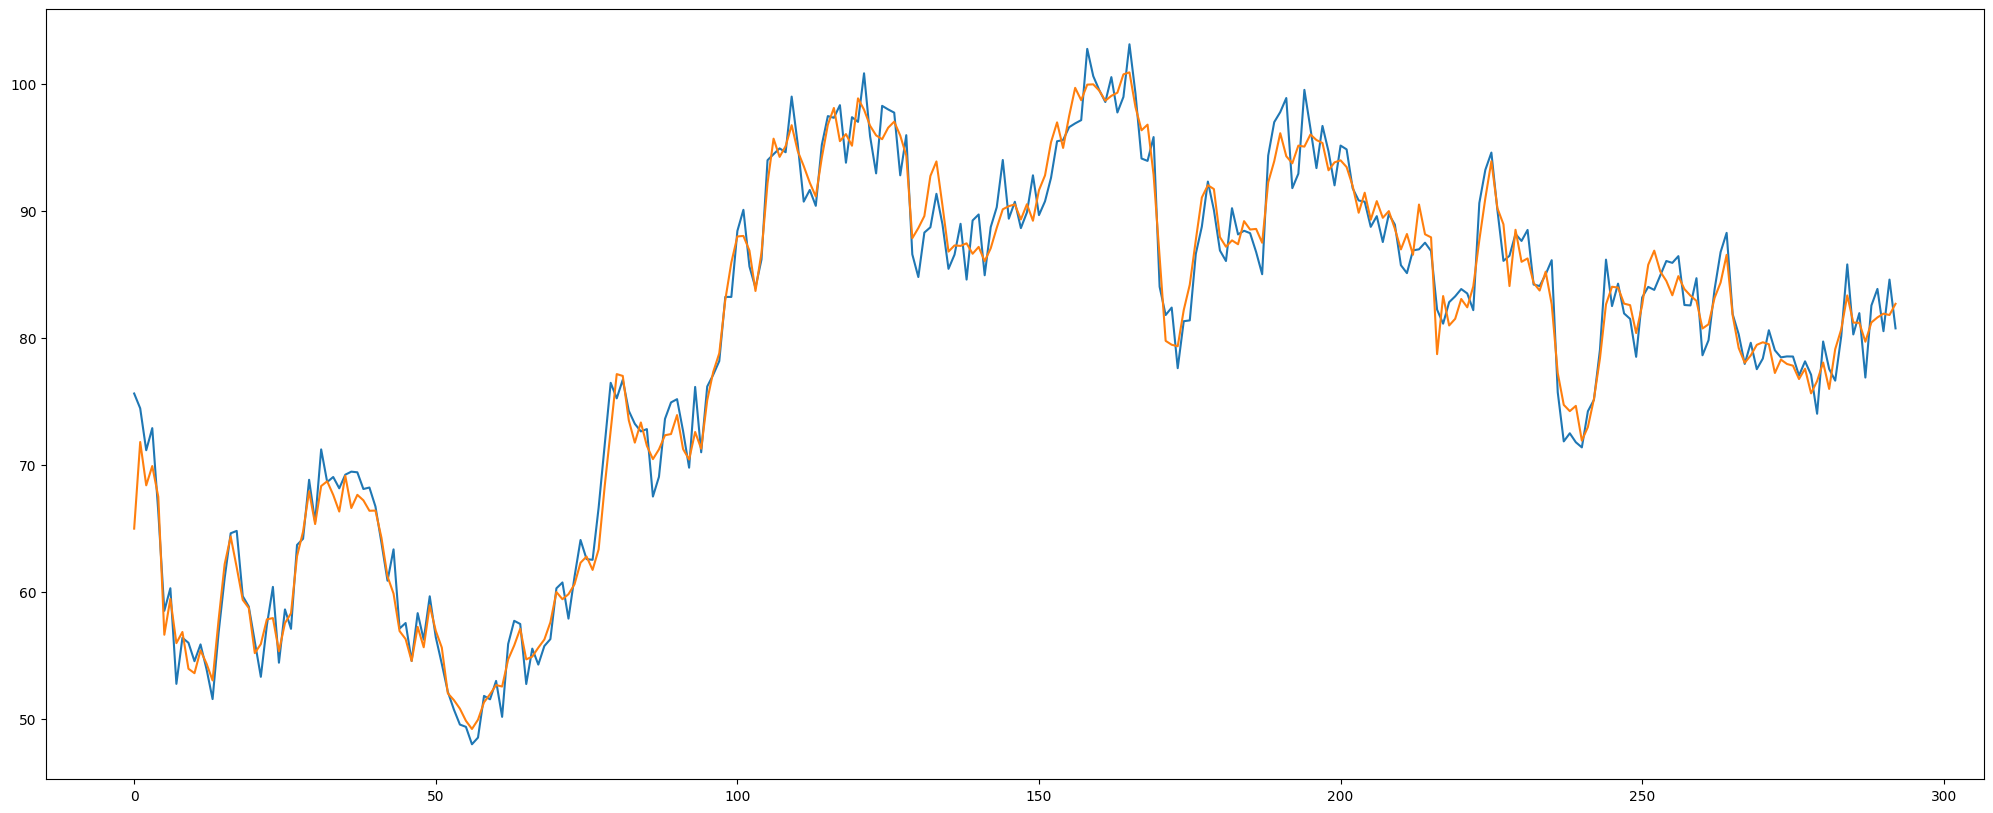

In [56]:
train['Close'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

In [57]:
y_pred = model_fit.predict()

# Assuming you have the true values in 'y_true'
y_true = train['Close']

# Calculate SMAPE
smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

print(f'SMAPE: {smape:.2f}%')

SMAPE: 1.93%


In [58]:
df_test.head()

,id,Date,Open,Volume,Lag_1_Open,Lag_2_Open,Lag_3_Open,Lag_4_Open,Lag_5_Open,Lag_1_Volume,...,OpenRoll8,OpenPriceDiffRoll2,OpenPriceDiffRoll4,OpenPriceDiffRoll3,OpenPriceDiffRoll5,Open_MA_Lag2_4,Open_MA_Lag2_2,Open_Seasonal,Open_Trend,Open_Residual
0,0,2021-03-01,72.708331,205897600,70.398916,70.551479,70.645342,70.750297,70.894525,1.977245e+08,...,70.687969,-0.171238,-0.136490,-0.146824,-0.133941,70.702571,70.597462,-3.434480,72.280007,0.503704
1,1,2021-03-08,73.310886,214095600,72.708331,70.551479,70.645342,70.750297,70.894525,2.058976e+08,...,70.687969,-0.171238,-0.136490,-0.146824,-0.133941,70.702571,70.551479,1.973019,72.280007,0.503704
2,2,2021-03-15,70.610119,151601700,73.310886,72.708331,70.645342,70.750297,70.894525,2.140956e+08,...,70.687969,-1.049106,-0.136490,-0.146824,-0.133941,70.702571,71.629905,3.092108,72.280007,0.503704
3,3,2021-03-22,70.256017,193982500,70.610119,73.310886,72.708331,70.750297,70.894525,1.516017e+08,...,70.687969,-1.527435,-0.136490,-0.817438,-0.133941,71.780544,73.009609,1.188503,72.280007,0.503704
4,4,2021-03-29,68.258324,220238400,70.256017,70.610119,73.310886,72.708331,70.894525,1.939825e+08,...,70.687969,-1.175897,-1.112502,-1.684187,-0.133941,71.795204,71.960503,0.770086,72.280007,0.503704


In [59]:
df_test.tail()

,id,Date,Open,Volume,Lag_1_Open,Lag_2_Open,Lag_3_Open,Lag_4_Open,Lag_5_Open,Lag_1_Volume,...,OpenRoll8,OpenPriceDiffRoll2,OpenPriceDiffRoll4,OpenPriceDiffRoll3,OpenPriceDiffRoll5,Open_MA_Lag2_4,Open_MA_Lag2_2,Open_Seasonal,Open_Trend,Open_Residual
95,95,2022-12-26,57.048622,224994700,55.184092,58.417757,59.428165,57.967017,60.016358,291865900.0,...,56.488386,-0.684568,-0.229599,-0.793181,-0.593547,58.957324,58.922961,-5.961406,72.280007,0.503704
96,96,2023-01-02,60.569661,176020500,57.048622,55.184092,58.417757,59.428165,57.967017,224994700.0,...,57.581369,2.692785,0.285374,0.717301,0.520529,57.749258,56.800924,-4.823187,72.280007,0.503704
97,97,2023-01-09,61.446777,181478600,60.569661,57.048622,55.184092,58.417757,59.428165,176020500.0,...,58.759806,2.199077,0.757255,2.087562,0.403722,57.519659,56.116357,-6.340152,72.280007,0.503704
98,98,2023-01-16,55.447711,162471700,61.446777,60.569661,57.048622,55.184092,58.417757,181478600.0,...,58.188725,-2.560975,0.065905,-0.533637,-0.594009,57.805033,58.809142,-3.872316,72.280007,0.503704
99,99,2023-01-23,57.008939,178924000,55.447711,61.446777,60.569661,57.048622,55.184092,162471700.0,...,58.068966,-2.218919,-0.009921,-1.186907,0.364970,58.562288,61.008219,-1.828917,72.280007,0.503704


In [60]:

predictions = model_fit.predict(start=len(train), end=len(train) + len(df_test) - 1, exog=sm.add_constant(df_test[['Lag_2_Open','Open_MA_Lag2_4','Lag_1_Open','Open_MA_Lag2_2','OpenRoll2','OpenRoll4','Open_Seasonal','OpenRoll8']]))
df_test['Close'] = predictions.values
closeprice_predictions = df_test['Close']

In [61]:
df_test['ClosePriceDiff'] = df_test['Close'].diff()

In [62]:
lag_features = ['ClosePriceDiff'
               ]
for feature in lag_features:
    df_test[feature].fillna(df_test[feature].mean(), inplace=True)

In [63]:
# Define the period for RSI (e.g., 14 days)
rsi_period = 4

# Calculate price changes
delta_1 = df_test['ClosePriceDiff']

# Calculate average gain and average loss
gain_1 = delta_1.where(delta > 0, 0)
loss_1 = -delta_1.where(delta < 0, 0)

avg_gain_1 = gain_1.rolling(window=rsi_period).mean()
avg_loss_1 = loss_1.rolling(window=rsi_period).mean()

# Calculate the relative strength (RS) and RSI
rs_1 = avg_gain_1 / avg_loss_1
rsi_1 = 100 - (100 / (1 + rs_1))

# Add RSI to the DataFrame if desired
df_test['RSI'] = rsi_1

In [64]:
# Define the short-term and long-term periods
short_term_period = 12
long_term_period = 26

# Calculate the short-term exponential moving average (EMA)
short_term_ema_1 = df_test['Close'].ewm(span=short_term_period, adjust=False).mean()

# Calculate the long-term exponential moving average (EMA)
long_term_ema_1 = df_test['Close'].ewm(span=long_term_period, adjust=False).mean()

# Calculate the MACD line
macd_line_1 = short_term_ema_1 - long_term_ema_1

# Calculate the signal line
signal_period = 9
signal_line_1 = macd_line_1.ewm(span=signal_period, adjust=False).mean()

In [65]:
# Define the period and number of standard deviations
bb_period = 5
num_std = 2

# Calculate the SMA (Simple Moving Average)
sma_1 = df_test['Close'].rolling(window=bb_period).mean()

# Calculate the standard deviation
std_1 = df_test['Close'].rolling(window=bb_period).std()

# Calculate the upper and lower Bollinger Bands
upper_bb_1 = sma_1 + (num_std * std)
lower_bb_1 = sma_1 - (num_std * std)


In [66]:
# Calculate OBV based on 'Volume'
df_test['OBV'] = df_test['Volume'] * (2 * (df_test['Close'] > df_test['Close'].shift()) - 1)
df_test['OBV'] = df_test['OBV'].cumsum()


In [67]:
df_test['RSI'] = rsi_1
df_test['MACD'] = macd_line_1
df_test['Signal Line'] = signal_line_1
df_test['Upper Band'] = upper_bb_1
df_test['Lower Band'] = lower_bb_1

In [68]:
lag_features = ['RSI','MACD','Signal Line','Upper Band','Lower Band','OBV'
               ]
for feature in lag_features:
    df_test[feature].fillna(df_test[feature].mean(), inplace=True)

In [69]:
df_test['Net'] = df_test['Close'] - df_test['Open']

In [70]:
lag_features = ['Net'
               ]
for feature in lag_features:
    df_test[feature].fillna(df_test[feature].mean(), inplace=True)

In [71]:

df_test['Net_2'] = df_test['Net'].rolling(window = 2).mean()
df_test['Net_4'] = df_test['Net'].rolling(window = 4).mean()
df_test['Net%'] = ((df_test['Close'] - df_test['Open']) / df['Open']) * 100
df_test['Lag_1_Close'] = df_test['Close'].shift(1)

In [72]:
df_test['Net%Roll2'] = df_test['Net%'].rolling(window=2).mean()
df_test['Net%Roll4'] = df_test['Net%'].rolling(window=4).mean()
df_test['Net%Roll3'] = df_test['Net%'].rolling(window=3).mean()
df_test['Net%Roll5'] = df_test['Net%'].rolling(window=5).mean()
df_test['ClosePriceDiffRoll2'] = df_test['ClosePriceDiff'].rolling(window=2).mean()
df_test['ClosePriceDiffRoll4'] = df_test['ClosePriceDiff'].rolling(window=4).mean()

In [73]:
lag_features = [
    'Net','Net_2','Net_4','Net%','Net%Roll2','Net%Roll4','Net%Roll3','Net%Roll5',
    'Lag_1_Close','ClosePriceDiffRoll2','ClosePriceDiffRoll4'    
]
for feature in lag_features:
    df_test[feature].fillna(df[feature].mean(), inplace=True)

In [74]:
df_test['Spread_Percentage'] = (df_test['Close'] - df_test['Open']) / df_test['Close']
df_test['Volume_Price_Impact'] = df_test['Volume'] * (df_test['Close'] - df_test['Open'])
df_test['Volume_Percentage_of_Prev'] = (df_test['Volume'] / df_test['Lag_1_Volume'])

In [75]:
lag_features = ['Spread_Percentage', 'Volume_Price_Impact','Volume_Percentage_of_Prev']
for feature in lag_features:
    df_test[feature].fillna(df[feature].mean(), inplace=True)

In [76]:
df_test['Daily_Return'] = (df_test['Close'] - df_test['Lag_1_Close'])

In [77]:
lag_features = ['Daily_Return']

for feature in lag_features:
    df_test[feature].fillna(df_test[feature].mean(), inplace=True)


In [78]:
df_test['Close-PrevClose'] = np.abs(df_test['Close'] - df_test['Open'].shift(1))
df_test['Open-PrevClose'] = np.abs(df_test['Open'] - df_test['Close'].shift(1))
df_test['TR'] = df_test[['Net', 'Close-PrevClose', 'Open-PrevClose']].max(axis=1)

In [79]:
df_test['ATR'] = df_test['TR'].rolling(window=4).mean()

In [80]:
df_test['DPR'] = df_test['Daily_Return']/df_test['Lag_1_Close']

In [81]:
lag_features = ['Daily_Return','TR','ATR','DPR'
               ]

for feature in lag_features:
    df_test[feature].fillna(df_test[feature].mean(), inplace=True)

In [82]:
train.columns

Index(['id', 'Date', 'Open', 'Close', 'Volume', 'Strategy', 'Net',
       'Lag_1_Open', 'Lag_2_Open', 'Lag_3_Open', 'Lag_4_Open', 'Lag_5_Open',
       'Lag_1_Close', 'Lag_2_Close', 'Lag_3_Close', 'Lag_1_Volume',
       'Lag_2_Volume', 'Lag_3_Volume', 'OpenPriceDiff', 'ClosePriceDiff',
       'Net_2', 'Net_4', 'Net%', 'OpenRoll2', 'OpenRoll4', 'OpenRoll8',
       'CloseRoll2', 'CloseRoll4', 'CloseRoll8', 'OpenPriceDiffRoll2',
       'OpenPriceDiffRoll4', 'ClosePriceDiffRoll2', 'ClosePriceDiffRoll4',
       'OpenPriceDiffRoll3', 'OpenPriceDiffRoll5', 'Net%Roll2', 'Net%Roll4',
       'Net%Roll3', 'Net%Roll5', 'Open_MA_Lag2_4', 'Open_MA_Lag2_2',
       'Open_Seasonal', 'Open_Trend', 'Open_Residual', 'Spread_Percentage',
       'Volume_Price_Impact', 'Volume_Percentage_of_Prev', 'Close_normalized',
       'Volume_normalized', 'Open_normalized', 'Daily_Return', 'DPR',
       'Close-PrevClose', 'Open-PrevClose', 'TR', 'ATR', 'RSI', 'OBV', 'MACD',
       'Signal Line', 'Upper Band', 'Lower Ban

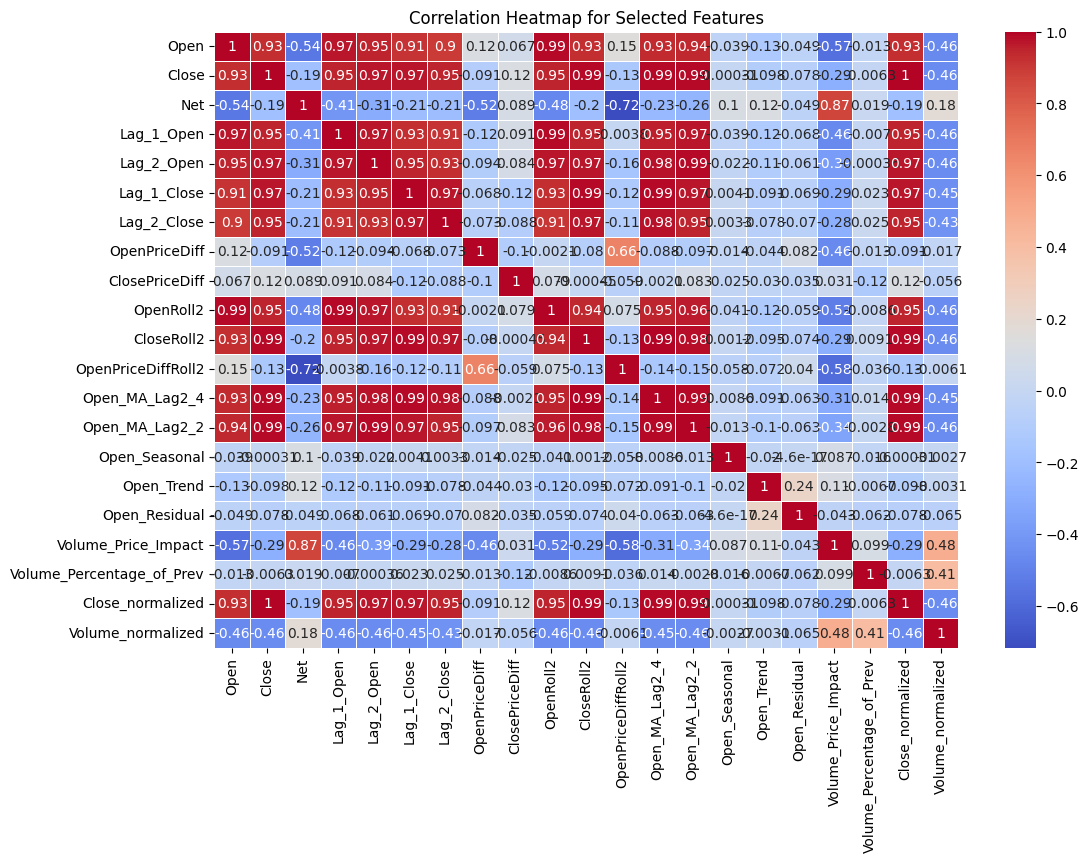

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the selected features
selected_features = [
    'Open', 'Close', 'Net',
    'Lag_1_Open', 'Lag_2_Open',
    'Lag_1_Close', 'Lag_2_Close', 'OpenPriceDiff', 'ClosePriceDiff', 'OpenRoll2',
    'CloseRoll2', 'OpenPriceDiffRoll2', 'Open_MA_Lag2_4', 'Open_MA_Lag2_2',
    'Open_Seasonal', 'Open_Trend', 'Open_Residual',
    'Volume_Price_Impact', 'Volume_Percentage_of_Prev', 'Close_normalized',
    'Volume_normalized'
]

# Create a subset of the dataset with the selected features
selected_data = train[selected_features]

# Calculate the correlation matrix for the selected features
correlation_matrix = selected_data.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap for Selected Features")
plt.show()



In [84]:
test.head()

,id,Date,Open,Close,Volume,Strategy,Net,Lag_1_Open,Lag_2_Open,Lag_3_Open,...,Close-PrevClose,Open-PrevClose,TR,ATR,RSI,OBV,MACD,Signal Line,Upper Band,Lower Band
293,293,2021-01-11,79.840215,84.324399,152163700,Sell,4.484184,80.490487,81.278395,80.361799,...,3.833913,0.900760,4.484184,4.071469,51.604244,903336500,0.682599,0.139867,86.809147,78.797629
294,294,2021-01-18,80.663736,83.889750,127248000,Sell,3.226013,79.840215,80.490487,81.278395,...,4.049535,3.660663,4.049535,4.212075,64.132491,776088500,0.815384,0.274970,86.828127,78.794986
295,295,2021-01-25,81.284821,83.373498,117281600,Sell,2.088676,80.663736,79.840215,80.490487,...,2.709761,2.604929,2.709761,3.834107,42.778045,658806900,0.868944,0.393765,86.475056,80.289766
296,296,2021-02-01,71.970249,85.294903,177655800,Sell,13.324653,81.284821,80.663736,79.840215,...,4.010081,11.403248,13.324653,6.142033,85.270425,836462700,1.054279,0.525868,86.942070,80.107340
297,297,2021-02-08,71.784627,83.266453,146003500,Hold,11.481825,71.970249,81.284821,80.663736,...,11.296203,13.510275,13.510275,8.398556,39.206291,690459200,1.025656,0.625825,85.679140,82.380461


In [85]:

features = ['ClosePriceDiff','RSI','MACD','Signal Line', 'Upper Band', 'Lower Band','OBV']


# Extract the features and target variable from the training set
X_train = train[features]
y_train = train['Strategy']

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

'''
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a Voting Classifier with the Random Forest classifier
voting_classifier = VotingClassifier(estimators=[('rf', rf_classifier)], voting='hard')

# Train the Voting Classifier on the training data
voting_classifier.fit(X_train, y_train)
'''

"\n# Initialize the Random Forest classifier\nrf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)\n\n# Create a Voting Classifier with the Random Forest classifier\nvoting_classifier = VotingClassifier(estimators=[('rf', rf_classifier)], voting='hard')\n\n# Train the Voting Classifier on the training data\nvoting_classifier.fit(X_train, y_train)\n"

In [86]:

X_test = test[features]
y_test = test['Strategy']
y_pred = rf_classifier.predict(X_test)


# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.8333333333333334


In [87]:
X_test = df_test[features]

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Add the predicted values to the test DataFrame as 'strategy_predict' column
df_test['strategy_predict'] = y_pred



In [88]:
submission_df = pd.DataFrame({
    'id': df_test['id'],
    'Date': df_test['Date'],
    'Close': closeprice_predictions,  # Include the forecasted 'Close' values
    'Strategy': df_test['strategy_predict']  # Replace with the appropriate strategy based on your model
})

# Save the submission to a CSV file
submission_df.to_csv('/kaggle/working/submission.csv', index=False)